In [13]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# For SVM stuff
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator
from sklearn_pandas import DataFrameMapper
from gensim.models.doc2vec import Doc2Vec

Format does basic work to change the format of columns into something we can use.

In [14]:
def format_df(df):
    df["deadline"] = pd.to_datetime(df["deadline"])
    df["launched"] = pd.to_datetime(df["launched"])
    df["success"] = df["pledged"] >= df["goal"]
    df["duration"] = df["deadline"] - df["launched"]
    return df

Clean removes columns we don't care about. Namely:
* When the duration is less than one day
* If the project state is 'live'
* If the project state is cancelled

In [15]:
# Taken from Michael's notebook
def clean_df(df):
    df = df.drop(df.loc[df["duration"] < datetime.timedelta(days=1)].index)
    df = df.drop(df.loc[df["state"] == "live"].index)
    df = df.drop(df.loc[df["state"] == "canceled"].index)
    return df

These functions define the transformations of the columns we care about into the forms we're interested in running actual algorithms on. 

In [27]:
def get_main_category_encoder():
    main_category_le = LabelEncoder()
    main_category_le.fit(train_clean['main_category'])
    return main_category_le

def get_category_encoder():
    category_le = LabelEncoder()
    category_le.fit(train_clean['category'])
    return category_le


def get_mapper():
    main_category_le = get_main_category_encoder()
    category_le = get_category_encoder()
    # TODO: names columns?
    mapper = DataFrameMapper([
        ('main_category', main_category_le),
        ('category', category_le),
        (['duration'], StandardScaler()),
        (['usd_goal_real'], StandardScaler()),
        (['launched_month', 'deadline_month'], OrdinalEncoder()),
    ], df_out=True)
    return mapper

def transform_df(df, mapper, fit=False):
    X = df[["name", "main_category", "category", "duration", "usd_goal_real"]].copy()
    X["launched_month"] = df["launched"].apply(lambda x: x.month)
    X["deadline_month"] = df["deadline"].apply(lambda x: x.month)
    X["duration"] = X["duration"].apply(lambda x: x.seconds)
    
    if fit:
        X_mapped = mapper.fit_transform(X)
    else:
        X_mapped = mapper.transform(X)
        
    y = df["success"].copy()
    
    return X_mapped, y, mapper
    

In [28]:
# Taken from Michael's notebook
train_full = pd.read_csv("data/2018-train.csv").dropna()
validate_full = pd.read_csv("data/2018-validate.csv").dropna()

In [29]:
# Taken from Michael's notebook
train_format = format_df(train_full)
validate_format = format_df(validate_full)

In [30]:
# Taken from Michael's notebook
train_clean = clean_df(train_format)
valid_clean = clean_df(validate_format)
train_clean.head()

,Unnamed: 0,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,success,duration
0,319122,695425648,Peace-building through story-making with youth...,Children's Books,Publishing,SEK,2015-06-09,6000.0,2015-05-10 14:53:53,6251.0,successful,15,SE,756.92,762.02,731.42,True,29 days 09:06:07
2,175494,189251239,Colored Baggies for Boardgames,Tabletop Games,Games,USD,2013-01-07,6000.0,2012-11-08 20:06:31,15151.0,successful,518,US,15151.00,15151.00,6000.00,True,59 days 03:53:29
4,141771,1720248225,Two Scoops of Beauty health wellness women eve...,Events,Food,USD,2016-09-04,5202.0,2016-08-05 01:26:56,0.0,failed,0,US,0.00,0.00,5202.00,False,29 days 22:33:04
5,236644,272982453,Gavarcia - Haute Couture in Canada,Couture,Fashion,CAD,2015-04-16,3000.0,2015-03-18 16:27:44,556.0,failed,8,CA,434.86,456.07,2460.83,False,28 days 07:32:16
6,231360,245912004,"""One Last Crazy F*cking Night"" (#OLCFN) The Movie",Narrative Film,Film & Video,USD,2013-03-01,50000.0,2013-01-30 17:55:02,3041.0,failed,28,US,3041.00,3041.00,50000.00,False,29 days 06:04:58


In [31]:
%%time
mapper = get_mapper()
X_train, y_train, mapper = transform_df(train_clean, mapper, fit=True)
X_valid, y_valid, mapper = transform_df(valid_clean, mapper, fit=False)

CPU times: user 5.38 s, sys: 25.1 ms, total: 5.41 s
Wall time: 4.01 s


In [8]:
%pip install textblob

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /Users/erika/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
from textblob import TextBlob
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/erika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/erika/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [35]:
X_train['blob'] = train_clean['name'].apply(lambda x: TextBlob(x))

In [38]:
X_train['polarity'] = X_train['blob'].apply(lambda x: x.polarity)
X_train['subjectivity'] = X_train['blob'].apply(lambda x: x.subjectivity)

[]

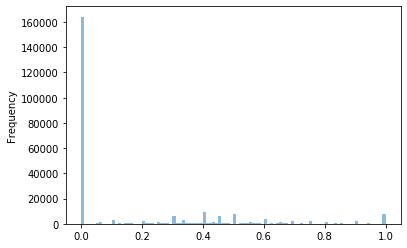

In [41]:
ax = X_train['subjectivity'].plot.hist(bins=100, alpha=0.5)
ax.plot()

[]

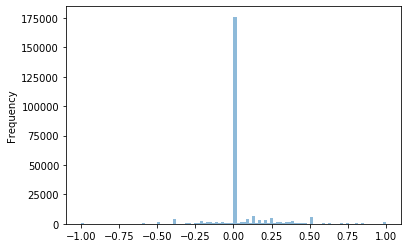

In [42]:
ax = X_train['polarity'].plot.hist(bins=100, alpha=0.5)
ax.plot()